### 建立Actor和Critic网络

这里针对简单的环境建立一个ActorCritic网络，并且只针对离散动作空间进行处理，演员和评论家共享参数。

In [1]:
import torch.nn as nn

class ActorCritic(nn.Module):
    ''' A2C网络模型，包含一个Actor和Critic
    '''
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        # 返回动作概率分布和价值
        return probs, value 

### 定义智能体-A3C算法的实现

A3C算法实际上是在A2C算法的基础上实现的，算法原理相同。A2C算法的基本原理是在演员-评论家算法的基础上引入优势函数的概念。评论家是一个函数逼近器，输入当前观测到的状态，输出评分值，也就是Q值。而Q值实际上可以分解为两部分，即Q(s,a)=A(s,a)+V(s)。其中A(s,a)即为优势函数，评价的是在给定状态下当前选定动作相较于其他动作的好坏，它可以通过采样数据计算得出。A2C算法的核心就在于让评论家学习A(s,a)而不再是学习Q(s,a)。

损失函数一般分为三项，策略梯度损失，值残差和策略熵正则。其中，策略梯度损失用于不断优化提升reward，值残差用于使critic网络不断逼近真实的reward，策略熵正则能够为了保证action的多样性，增加智能体探索能力。

In [2]:

import torch
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical

class Policy:
    def __init__(self, cfg):
        self.model = ActorCritic(cfg.state_dim, cfg.action_dim, cfg.hidden_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg.lr)
        self.device = torch.device(cfg.device)
        self.gamma = cfg.gamma
        
    def sample_action(self, state):
        state = torch.tensor(np.array(state), dtype=torch.float, device=self.device) # [batch_size, state_dim]
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        probs, self.value = self.model(state)
        dist = Categorical(probs)
        action = dist.sample()
        self.log_prob = dist.log_prob(action)
        return action.cpu().numpy()[0]

    def predict_action(self, state):
        state = torch.tensor(np.array(state), dtype=torch.float, device=self.device)
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        probs, value = self.model(state)
        return probs.argmax(dim=1).cpu().numpy()[0]
    
    def get_policy_transition(self):
        policy_transition = {'log_prob':self.log_prob.detach().cpu().numpy().item(), 'value': self.value.detach().cpu().numpy().item()}
        return policy_transition
        
    def learn(self, **kwargs):
        states, actions, returns= kwargs['states'], kwargs['actions'], kwargs['returns']
        values = kwargs['values']
        probs, values = self.model(states)
        dist = Categorical(probs)
        entropy = dist.entropy().mean()
        log_probs = dist.log_prob(actions).unsqueeze(1)
        advantages = returns - values
        actor_loss = - (log_probs * advantages.detach()).mean() 
        critic_loss = advantages.pow(2).mean()
        loss = actor_loss + 0.5* critic_loss - 0.001 * entropy
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return actor_loss.item(), critic_loss.item()

### 定义训练

在A3C的训练过程中，通过n_envs定义多个环境，构建多个工作进程，所有的工作进程都会在每个相同的时间步上进行环境交互，经过n_steps步的交互之后，将经验收集后一起计算梯度进行模型更新。需要注意的是，这里在多进程的构建上采用的是同步更新的方法，即在每个时间步上使用的是相同的模型和策略进行交互。

In [3]:
import copy
import gymnasium as gym
import ray
from utils.vev_env import EnvWorker, evaluate_policy
from utils.experience import compute_returns_for_exps

def train(cfg):
    ''' 训练
    '''
    env = gym.make(cfg.env_id)
    setattr(cfg, "action_space", env.action_space)
    setattr(cfg, "state_dim", env.observation_space.shape[0])
    setattr(cfg, "action_dim", env.action_space.n)
    env_workers = [EnvWorker.remote(cfg, copy.deepcopy(env), idx) for idx in range(cfg.n_envs)]
    policy = Policy(cfg)
    frames, test_rewards = [], []
    threshold_reward_cnt = 0
    for i in range(cfg.max_frame):
        exps = ray.get([worker.run.remote(policy) for worker in env_workers])
        exps = [compute_returns_for_exps(exp, gamma = cfg.gamma, gae_lambda = cfg.gae_lambda) for exp in exps]
        exps = [exp for sublist in exps for exp in sublist]
        states = torch.tensor(np.array([exp.state for exp in exps]), dtype=torch.float, device=policy.device)
        actions = torch.tensor(np.array([exp.action for exp in exps]), dtype=torch.long, device=policy.device)
        log_probs = torch.tensor(np.array([exp.log_prob for exp in exps]), dtype=torch.float, device=policy.device)
        rewards = torch.tensor(np.array([exp.reward for exp in exps]), dtype=torch.float, device=policy.device)
        values = torch.tensor(np.array([exp.value for exp in exps]), dtype=torch.float, device=policy.device)
        returns = torch.tensor(np.array([exp.return_td_normed for exp in exps]), dtype=torch.float, device=policy.device).unsqueeze(1)
        actor_loss, critic_loss = policy.learn(states=states, actions=actions, log_probs=log_probs, values=values, returns=returns)
        if i % 10 == 0:
            frames.append(i)
            test_reward = evaluate_policy(env, policy)
            test_rewards.append(test_reward)
            print(f"Frame: {i}, Reward: {test_reward}")
            if test_reward >= cfg.threshold_reward:
                threshold_reward_cnt += 1
        if threshold_reward_cnt >= cfg.threshold_reward_cnt:
            print(f"Threshold reward reached over {cfg.threshold_reward_cnt} times, stop training!")
            break
    return {'frames':frames, 'rewards':test_rewards}

    

### 设置参数

In [4]:
class Config:
    def __init__(self):
        self.algo_name = "A3C"
        self.env_id = "CartPole-v1"
        self.mode = "train"
        self.n_envs = 10
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.max_frame = 1000000
        self.max_step = 200
        self.seed = 1
        self.hidden_dim = 256
        self.lr = 3e-4
        self.n_steps = 20
        self.n_epochs = 4
        self.threshold_reward = 200 # 目标reward
        self.threshold_reward_cnt = 10 # 如果连续N次达到目标reward则停止训练
        self.gamma = 0.95
        self.gae_lambda = 0.95

### 开始训练

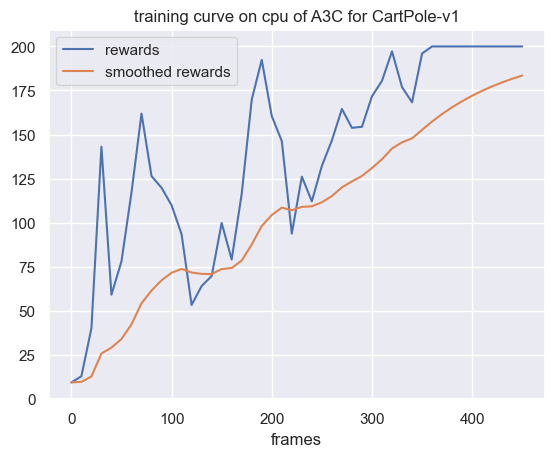

In [5]:
import ray
from utils.utils import plot_rewards
cfg = Config()
res = train(cfg)
plot_rewards(cfg, res['frames'], res['rewards'])
ray.shutdown()